<a href="https://colab.research.google.com/github/Vinicius-Quadros/Pratica_Maquina/blob/main/Tarefa_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IRIS

In [ ]:
# Instalação de bibliotecas (se necessário)
!pip install -q seaborn
!pip install -q imbalanced-learn

# Importação de bibliotecas
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay,
                             roc_curve, auc)
# Carregar dataset
##Dataset Iris: Contém 150 amostras de 3 espécies de íris (Setosa, Versicolor, Virginica), com 4 características cada (comprimento e largura de sépala e pétala).
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

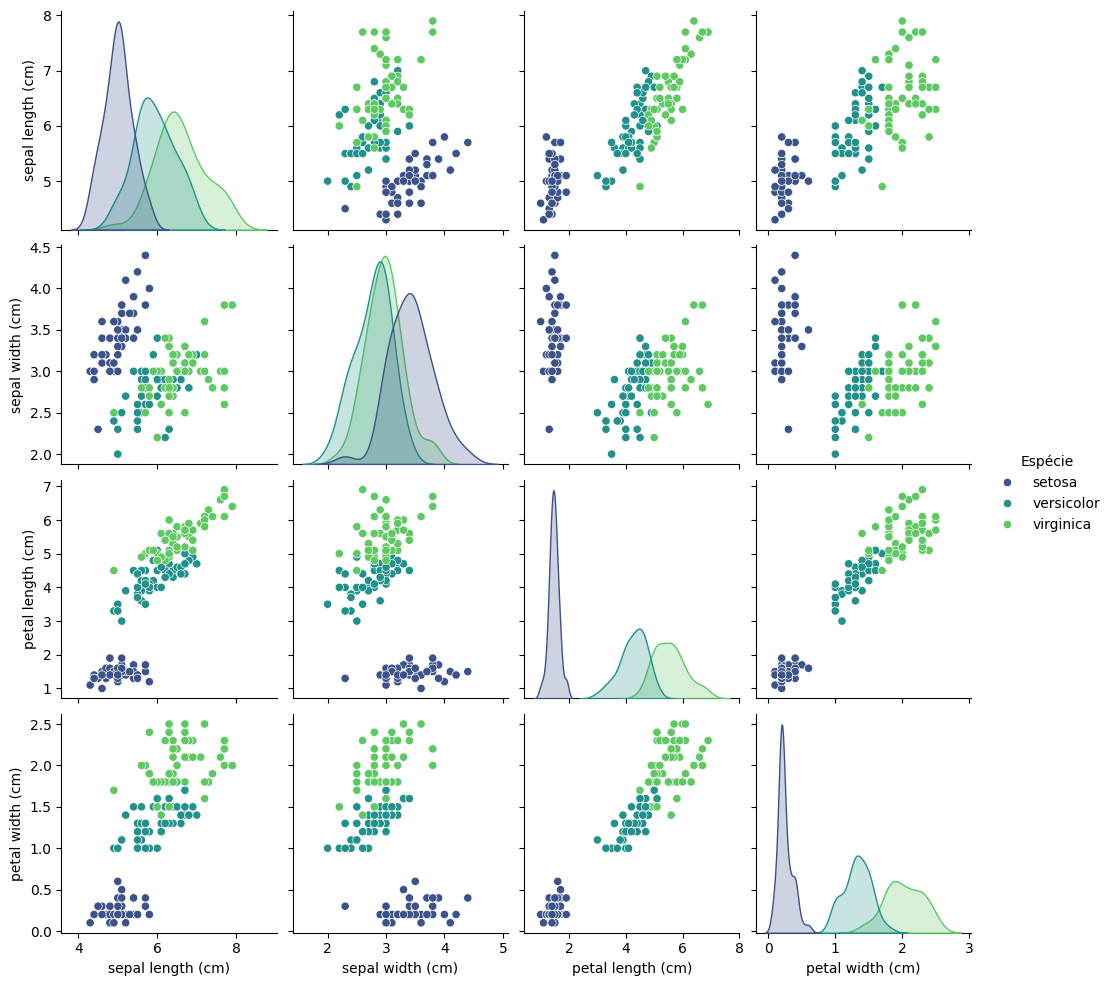

In [ ]:
# Análise Exploratória (EDA)
##Propósito: Visualizar relações entre as features e distribuição das classes.
##Saída: Um gráfico de pares (pairplot) que mostra:
##Histogramas (diagonal) para distribuição de cada feature por espécie.
##Gráficos de dispersão (off-diagonal) para relações entre features

df_iris = pd.DataFrame(X, columns=feature_names)
df_iris['Espécie'] = y
df_iris['Espécie'] = df_iris['Espécie'].map({0: class_names[0], 1: class_names[1], 2: class_names[2]})
sns.pairplot(df_iris, hue='Espécie', palette='viridis')
plt.show()

In [ ]:
# Pré-processamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=80)

In [ ]:
# Padronização para SVM
##Padronização:
##Necessária para o SVM (sensível à escala).
##Não aplicada para Árvores de Decisão e Gradient Boosting (não dependem de escala).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Função para avaliação multiclasse
##Métricas Calculadas:
##Classification Report: Precisão, recall, F1-score por classe.
##Matriz de Confusão: Visualiza acertos e erros por classe.
##ROC-AUC: Mede a capacidade de discriminação entre classes (quanto mais próximo de 1, melhor).
##Curvas ROC: Mostra o trade-off entre taxa de verdadeiros positivos (TPR) e falsos positivos (FPR).
def evaluate_multiclass(model, X_test, y_test, class_names, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    print(f"{model_name} - Relatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Métrica MAE para avaliação ordinal
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} - Mean Absolute Error (MAE): {mae:.2f}\n")

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names, cmap='Blues')
    plt.title(f'{model_name} - Matriz de Confusão')
    plt.show()

    # ROC-AUC Multiclasse
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    roc_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
    print(f"{model_name} - ROC-AUC (OvR): {roc_auc:.2f}\n")

    # Curvas ROC por classe
    n_classes = len(class_names)
    fpr, tpr = {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {auc(fpr[i], tpr[i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'{model_name} - Curvas ROC por Classe')
    plt.legend()
    plt.show()

SVM - Relatório de Classificação:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        34
  versicolor       0.96      0.63      0.76        43
   virginica       0.63      0.96      0.76        28

    accuracy                           0.84       105
   macro avg       0.86      0.86      0.84       105
weighted avg       0.89      0.84      0.84       105

SVM - Mean Absolute Error (MAE): 0.16



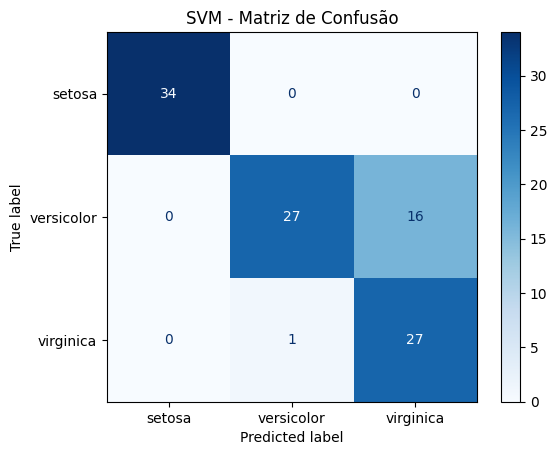

SVM - ROC-AUC (OvR): 0.99



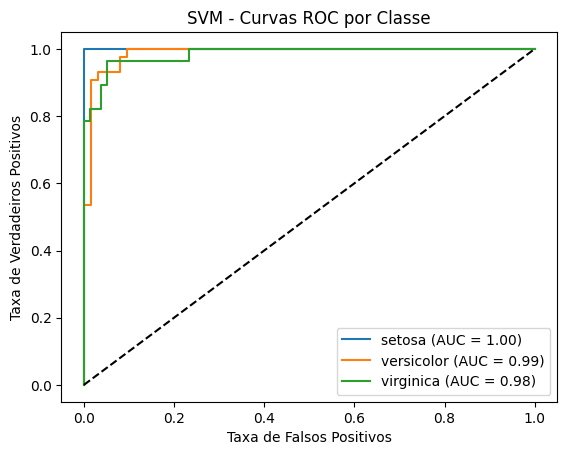


Análise de Outliers:

Outliers em sepal length (cm): 0 amostras
Outliers em sepal width (cm): 4 amostras
Valores dos outliers em sepal width (cm):
 sepal width (cm)  target
              4.4       0
              4.1       0
              4.2       0
              2.0       1


Outliers em petal length (cm): 0 amostras
Outliers em petal width (cm): 0 amostras


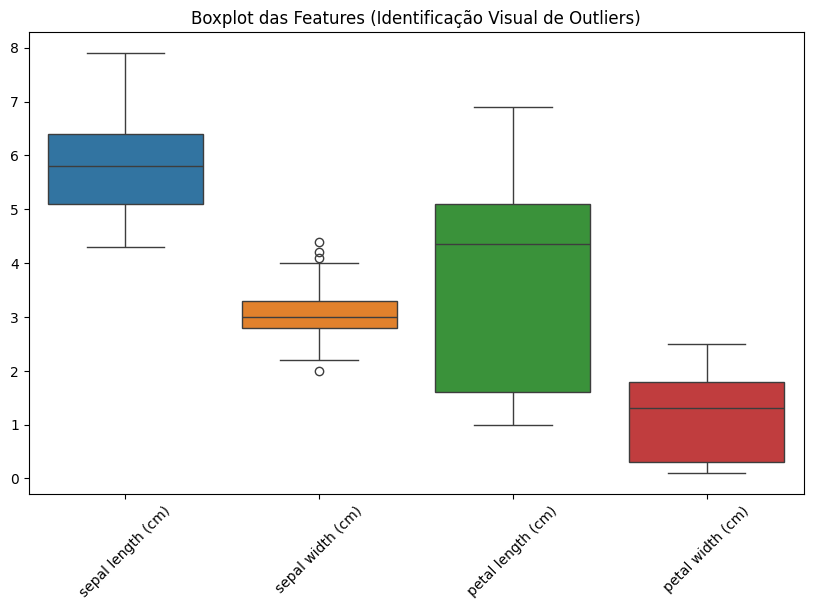


Decisão: Os outliers identificados são valores naturais das diferentes espécies de íris e serão mantidos.



In [ ]:
# Treinar e avaliar SVM
##Usa dados padronizados.
##probability=True: Habilita cálculo de probabilidades para ROC-AUC.
##Kernel padrão: RBF (não linear).
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
evaluate_multiclass(svm, X_test_scaled, y_test, class_names, "SVM")

# Tratamento de Outliers
## Identificação e remoção de outliers usando o método IQR
print("\nAnálise de Outliers:\n")

# Criar DataFrame para análise
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Função para identificar outliers
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

# Verificar outliers por feature
for feature in feature_names:
    outliers = detect_outliers(df, feature)
    print(f"Outliers em {feature}: {len(outliers)} amostras")
    if len(outliers) > 0:
        print(f"Valores dos outliers em {feature}:")
        print(outliers[[feature, 'target']].to_string(index=False))
        print("\n")

# Visualização de outliers com boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_iris.drop(columns=['Espécie']))
plt.title('Boxplot das Features (Identificação Visual de Outliers)')
plt.xticks(rotation=45)
plt.show()

# Decisão sobre tratamento de outliers
## No dataset Iris, os "outliers" são geralmente valores extremos naturais das diferentes espécies
## Portanto, decidimos NÃO remover esses pontos, pois são informações válidas
## Em outros contextos, poderíamos:
## 1. Remover os registros com outliers
## 2. Substituir pelos valores limites (winsorization)
## 3. Transformar os dados (log, sqrt, etc.)
print("\nDecisão: Os outliers identificados são valores naturais das diferentes espécies de íris e serão mantidos.\n")

Árvore de Decisão - Relatório de Classificação:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        34
  versicolor       0.97      0.86      0.91        43
   virginica       0.82      0.96      0.89        28

    accuracy                           0.93       105
   macro avg       0.93      0.94      0.93       105
weighted avg       0.94      0.93      0.93       105

Árvore de Decisão - Mean Absolute Error (MAE): 0.07



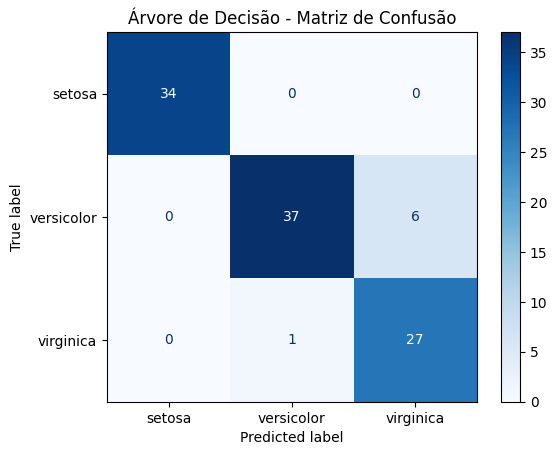

Árvore de Decisão - ROC-AUC (OvR): 0.96



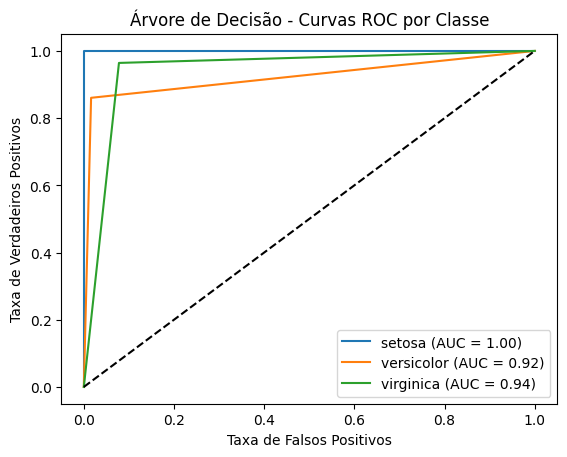

In [ ]:
# Treinar e avaliar Árvore de Decisão
##Não requer padronização.
##Sensível a overfitting (hiperparâmetros como max_depth podem ser ajustados).
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
evaluate_multiclass(dt, X_test, y_test, class_names, "Árvore de Decisão")

Gradient Boosting - Relatório de Classificação:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        34
  versicolor       0.97      0.86      0.91        43
   virginica       0.82      0.96      0.89        28

    accuracy                           0.93       105
   macro avg       0.93      0.94      0.93       105
weighted avg       0.94      0.93      0.93       105

Gradient Boosting - Mean Absolute Error (MAE): 0.07



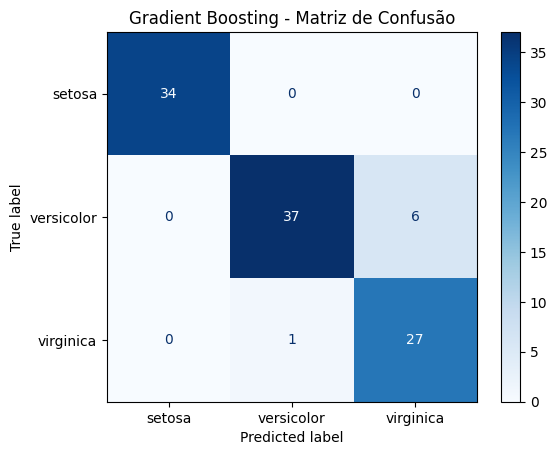

Gradient Boosting - ROC-AUC (OvR): 0.94



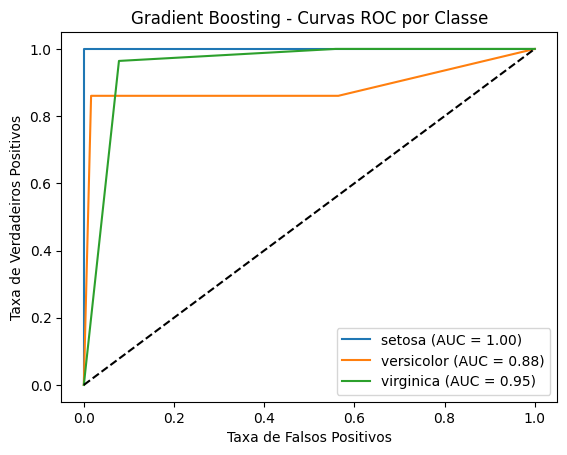

In [ ]:
# Treinar e avaliar Gradient Boosting
##Ensemble de árvores de decisão fracas.
##Minimiza erro sequencialmente (boosting).
##Geralmente mais preciso que modelos individuais.
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
evaluate_multiclass(gb, X_test, y_test, class_names, "Gradient Boosting")

Distribuição antes do SMOTE: Counter({np.int64(1): 37, np.int64(2): 37, np.int64(0): 31})
Distribuição após o SMOTE: Counter({np.int64(1): 37, np.int64(2): 37, np.int64(0): 37})
SVM com SMOTE - Relatório de Classificação:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

SVM com SMOTE - Mean Absolute Error (MAE): 0.00



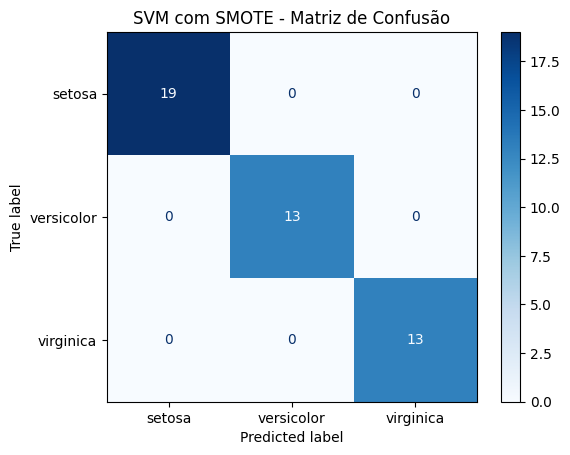

SVM com SMOTE - ROC-AUC (OvR): 1.00



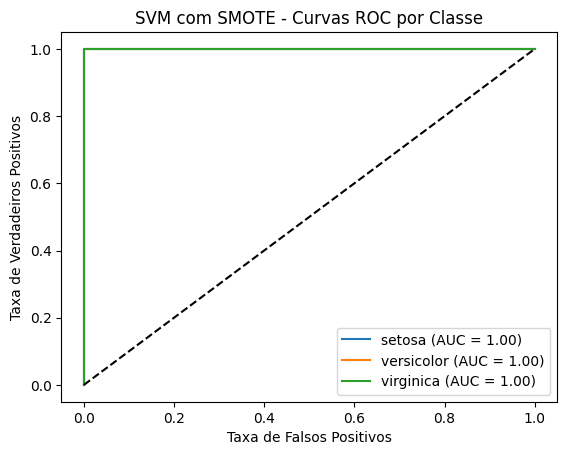

Árvore com SMOTE - Relatório de Classificação:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Árvore com SMOTE - Mean Absolute Error (MAE): 0.00



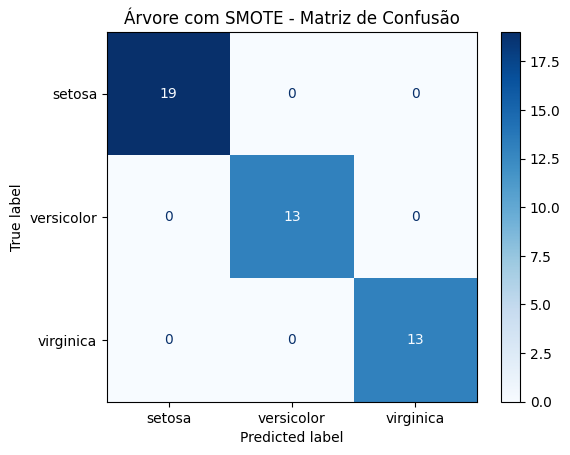

Árvore com SMOTE - ROC-AUC (OvR): 1.00



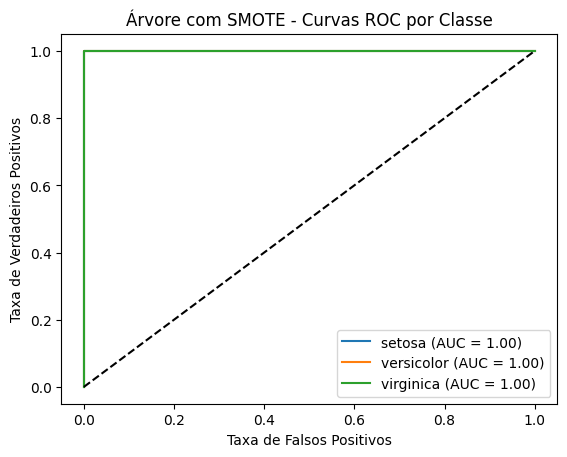

GB com SMOTE - Relatório de Classificação:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

GB com SMOTE - Mean Absolute Error (MAE): 0.00



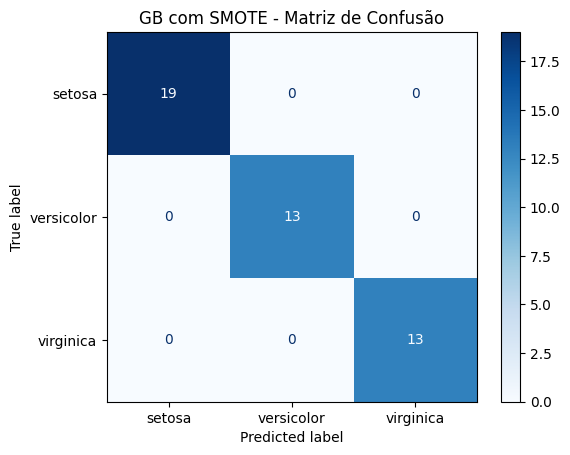

GB com SMOTE - ROC-AUC (OvR): 1.00



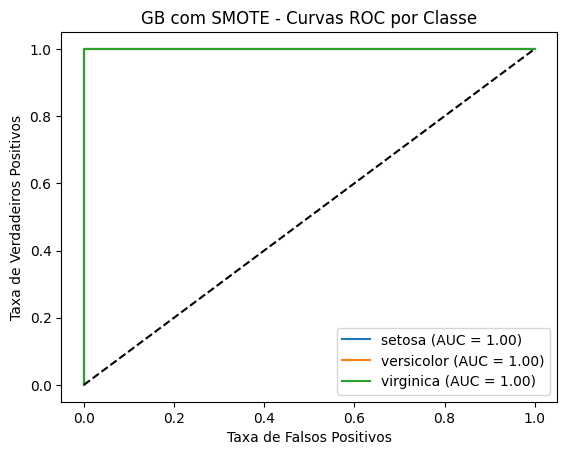

In [ ]:
# Divisão normal dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Verificar distribuição antes
print("Distribuição antes do SMOTE:", Counter(y_train))

# Aplicar SMOTE apenas nos dados de treino
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verificar distribuição após
print("Distribuição após o SMOTE:", Counter(y_train_smote))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)  # Usar dados com SMOTE
X_test_scaled = scaler.transform(X_test)  # Manter teste original

# SVM
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train_smote)  # Treinar com dados SMOTE

# Árvore de Decisão
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_smote, y_train_smote)  # Treinar com dados SMOTE (sem escalar)

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_smote, y_train_smote)  # Treinar com dados SMOTE (sem escalar)

# Avaliar sempre no conjunto de teste original
evaluate_multiclass(svm, X_test_scaled, y_test, class_names, "SVM com SMOTE")
evaluate_multiclass(dt, X_test, y_test, class_names, "Árvore com SMOTE")
evaluate_multiclass(gb, X_test, y_test, class_names, "GB com SMOTE")

# Wine Quality - Red

Distribuição das classes:
target
0    1382
1     217
Name: count, dtype: int64


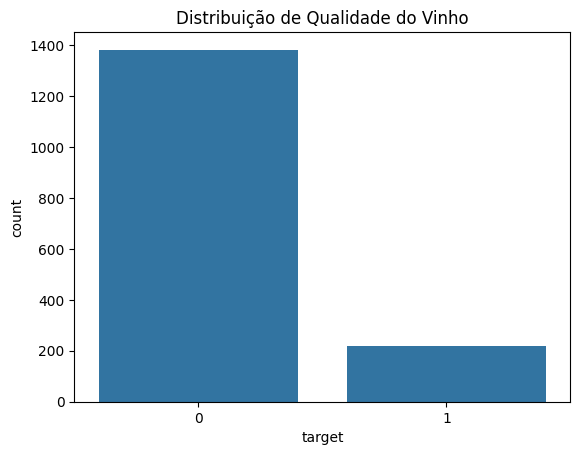

In [1]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV  # Para otimização de hiperparâmetros

# Carregar dataset
##Dataset Wine Quality: Contém 1,599 amostras de vinhos tintos com 11 características físico-químicas (ex: acidez, pH, álcool).
##Transformação do Target:
##Problema binário: Classificar vinhos como "Bom" (≥7) ou "Ruim" (<7).
##Motivo: Simplificar o problema (originalmente multiclasse de 3 a 8).
##
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')

# Criar target binário (qualidade >=7 é "Bom")
#Insight: Desbalanceamento significativo (apenas ~13% são "Bons"), o que exige cuidado na avaliação (ex: ROC-AUC é mais confiável que acurácia).
df['target'] = df['quality'].apply(lambda x: 1 if x >=7 else 0)
X = df.drop(['quality', 'target'], axis=1)
y = df['target']

# Análise Exploratória (EDA)
print("Distribuição das classes:")
print(df['target'].value_counts())
sns.countplot(x='target', data=df)
plt.title('Distribuição de Qualidade do Vinho')
plt.show()

In [2]:
# Pré-processamento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Padronização para SVM
##Padronização:
##Necessária para SVM (sensível à escala).
##Não aplicada para Árvores e Gradient Boosting (não dependem de escala).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
# Função para avaliação binária
##Classification Report: Precisão, recall, F1-score para cada classe.
##Matriz de Confusão: Visualiza falsos positivos/negativos.
##ROC-AUC: Mede a capacidade de distinguir entre classes (ideal para dados desbalanceados).
def evaluate_binary(model, X_test, y_test, model_name, scaled=False):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    print(f"{model_name} - Relatório de Classificação:")
    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Ruim', 'Bom'], cmap='Blues')
    plt.title(f'{model_name} - Matriz de Confusão')
    plt.show()
##    Matriz de Confusão: Mostra quantos "Bons" foram classificados como "Ruins" e vice-versa.
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"{model_name} - ROC-AUC: {roc_auc:.2f}")
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f'{model_name} - Curva ROC')
    plt.show()
##Curva ROC: AUC próxima de 1 indica bom desempenho (ex: AUC = 0.85).

SVM - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       415
           1       0.88      0.34      0.49        65

    accuracy                           0.90       480
   macro avg       0.89      0.67      0.72       480
weighted avg       0.90      0.90      0.89       480



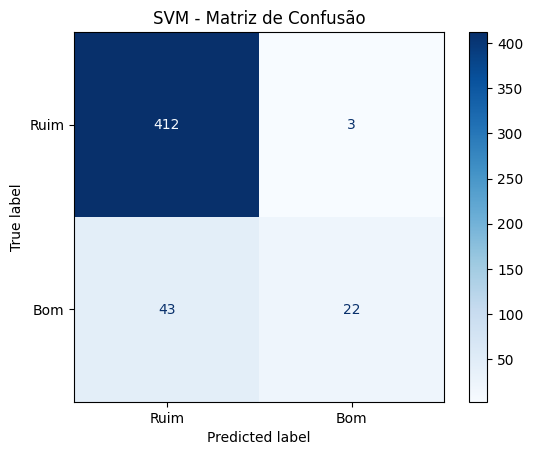

SVM - ROC-AUC: 0.85


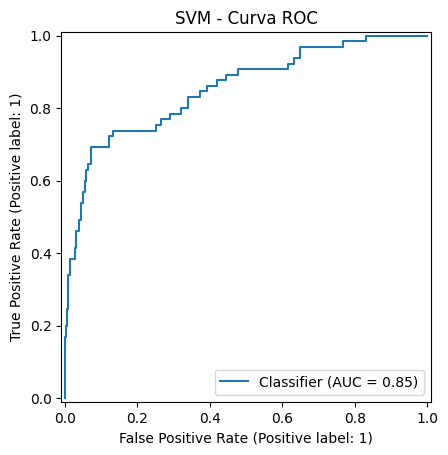

In [4]:
# Treinar e avaliar SVM
##probability=True: Permite calcular probabilidades para ROC-AUC.
##Kernel padrão: RBF (não linear).
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
evaluate_binary(svm, X_test_scaled, y_test, "SVM", scaled=True)

Árvore de Decisão - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       415
           1       0.60      0.51      0.55        65

    accuracy                           0.89       480
   macro avg       0.76      0.73      0.74       480
weighted avg       0.88      0.89      0.88       480



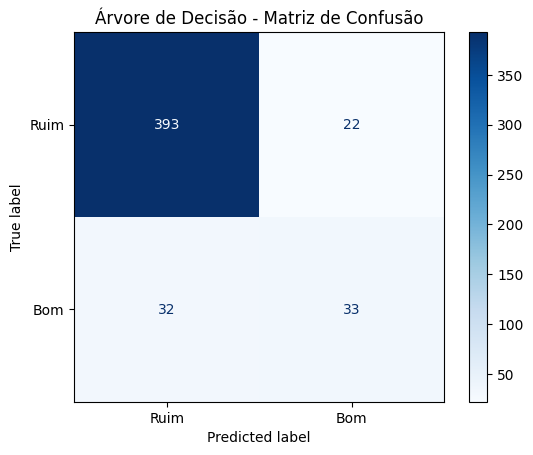

Árvore de Decisão - ROC-AUC: 0.73


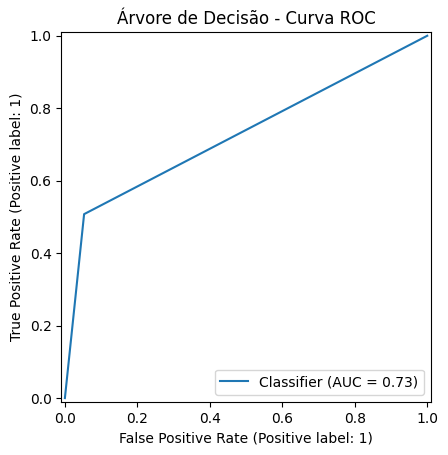

In [5]:
# Treinar e avaliar Árvore de Decisão
##Não requer padronização.
##Sensível a overfitting (pode ser controlado com max_depth ou min_samples_split).
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
evaluate_binary(dt, X_test, y_test, "Árvore de Decisão")

Gradient Boosting - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       415
           1       0.78      0.45      0.57        65

    accuracy                           0.91       480
   macro avg       0.85      0.71      0.76       480
weighted avg       0.90      0.91      0.90       480



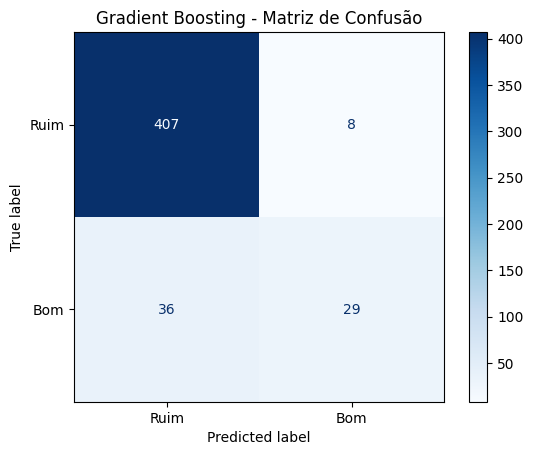

Gradient Boosting - ROC-AUC: 0.91


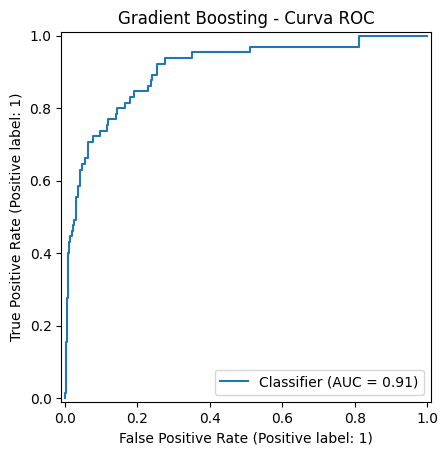


Validação Cruzada (5 folds) - Gradient Boosting:
AUC médio: 0.86 (± 0.02)
Gradient Boosting - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       415
           1       0.78      0.45      0.57        65

    accuracy                           0.91       480
   macro avg       0.85      0.71      0.76       480
weighted avg       0.90      0.91      0.90       480



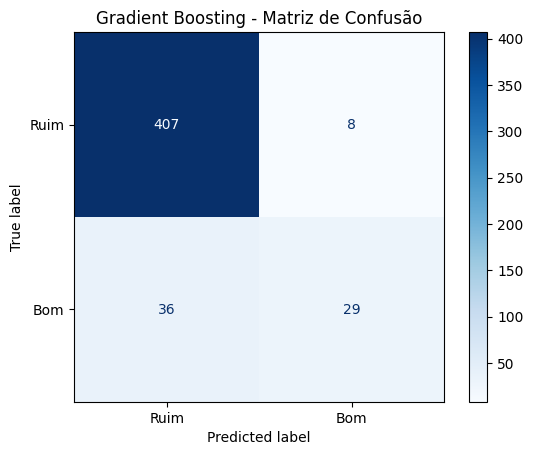

Gradient Boosting - ROC-AUC: 0.91


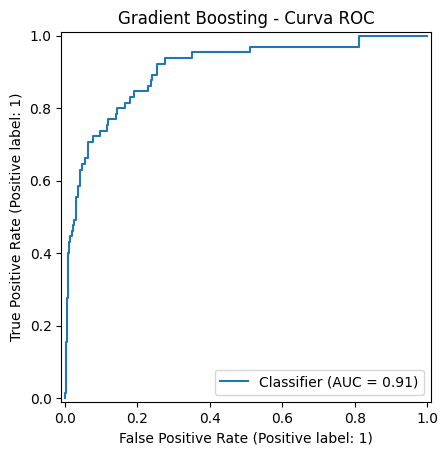


Melhores hiperparâmetros encontrados:
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}
Gradient Boosting Otimizado - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       415
           1       0.83      0.46      0.59        65

    accuracy                           0.91       480
   macro avg       0.88      0.72      0.77       480
weighted avg       0.91      0.91      0.90       480



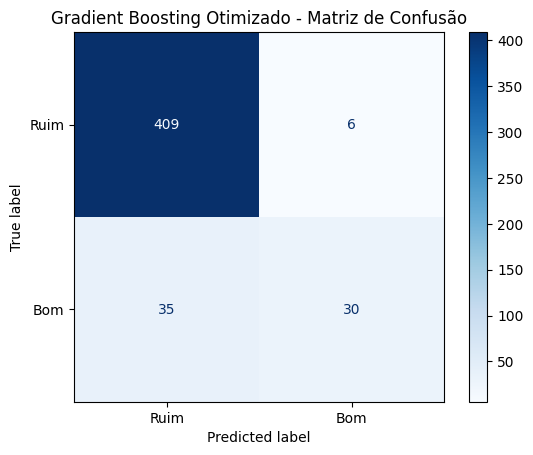

Gradient Boosting Otimizado - ROC-AUC: 0.90


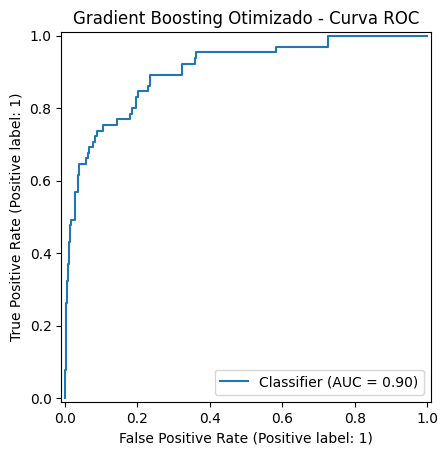

In [6]:
# Treinar e avaliar Gradient Boosting
##Ensemble de árvores de decisão (combina modelos fracos sequencialmente).
##Menos propenso a overfitting que árvores individuais.
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
evaluate_binary(gb, X_test, y_test, "Gradient Boosting")


# Treinar e avaliar Gradient Boosting com Validação Cruzada
gb = GradientBoostingClassifier(random_state=42)

# Configurar validação cruzada estratificada (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliação com validação cruzada
cv_scores = cross_val_score(gb, X_train, y_train, cv=cv, scoring='roc_auc')
print("\nValidação Cruzada (5 folds) - Gradient Boosting:")
print(f"AUC médio: {cv_scores.mean():.2f} (± {cv_scores.std():.2f})")

# Treinar o modelo final com todos os dados de treino
gb.fit(X_train, y_train)

# Avaliação no conjunto de teste
evaluate_binary(gb, X_test, y_test, "Gradient Boosting")

# [Opcional] Otimização de hiperparâmetros com GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42),
                         param_grid,
                         cv=cv,
                         scoring='roc_auc',
                         n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nMelhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

# Avaliar o melhor modelo no conjunto de teste
best_gb = grid_search.best_estimator_
evaluate_binary(best_gb, X_test, y_test, "Gradient Boosting Otimizado")

In [ ]:
def prever_manual():
    """
    Função para prever a qualidade do vinho (Bom ou Ruim) com base em valores inseridos manualmente.
    Utiliza o modelo Gradient Boosting otimizado treinado anteriormente.

    Requer a entrada dos seguintes parâmetros (características do vinho):
    - fixed acidity
    - volatile acidity
    - citric acid
    - residual sugar
    - chlorides
    - free sulfur dioxide
    - total sulfur dioxide
    - density
    - pH
    - sulphates
    - alcohol

    Retorna a probabilidade de ser "Bom" (>=7) e a classificação final.
    """

    # Verificar se o modelo otimizado foi treinado
    if 'best_gb' not in globals():
        raise ValueError("Modelo Gradient Boosting não foi treinado. Execute o GridSearchCV primeiro.")

    print("Insira os valores das características do vinho para prever a qualidade (Bom >=7 / Ruim <7):")

    # Coletar inputs do usuário
    features = [
        'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
        'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
        'pH', 'sulphates', 'alcohol'
    ]

    input_data = []
    for feature in features:
        value = float(input(f"{feature}: "))
        input_data.append(value)

    # Criar DataFrame com os dados de entrada
    input_df = pd.DataFrame([input_data], columns=features)

    # Fazer a previsão
    proba = best_gb.predict_proba(input_df)[0][1]  # Probabilidade de ser "Bom"
    prediction = best_gb.predict(input_df)[0]       # Classificação (0 ou 1)

    # Exibir resultados
    print("\nResultado da Predição:")
    print(f"- Probabilidade de ser 'Bom': {proba*100:.1f}%")
    print(f"- Classificação: {'Bom (>=7)' if prediction == 1 else 'Ruim (<7)'}")

    return {"probabilidade": proba, "classificacao": prediction}

# Exemplo de uso:
prever_manual()

Insira os valores das características do vinho para prever a qualidade (Bom >=7 / Ruim <7):
fixed acidity: 7.4
volatile acidity: 0.7
citric acid: 0.0
residual sugar: 1.9
chlorides: 0.076
free sulfur dioxide: 11
total sulfur dioxide: 34
density: 0.9978
pH: 3.51
sulphates: 0.56
alcohol: 9.4

Resultado da Predição:
- Probabilidade de ser 'Bom': 1.2%
- Classificação: Ruim (<7)


{'probabilidade': np.float64(0.0122514555718434), 'classificacao': np.int64(0)}

fixed acidity: 7.4
volatile acidity: 0.7
citric acid: 0.0
residual sugar: 1.9
chlorides: 0.076
free sulfur dioxide: 11
total sulfur dioxide: 34
density: 0.9978
pH: 3.51
sulphates: 0.56
alcohol: 9.4

# Wine Quality - White

Distribuição das classes:
target
0    3838
1    1060
Name: count, dtype: int64


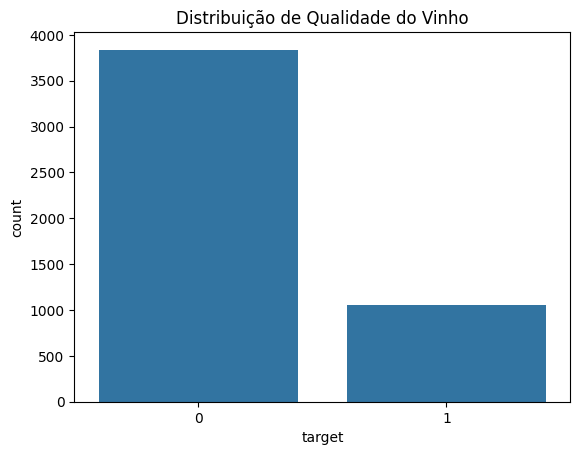

In [7]:
# Importação de bibliotecas
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay)

# Carregar dataset
##Dataset Wine Quality: Contém 1,599 amostras de vinhos tintos com 11 características físico-químicas (ex: acidez, pH, álcool).
##Transformação do Target:
##Problema binário: Classificar vinhos como "Bom" (≥7) ou "Ruim" (<7).
##Motivo: Simplificar o problema (originalmente multiclasse de 3 a 8).
##
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
df = pd.read_csv(url, sep=';')

# Criar target binário (qualidade >=7 é "Bom")
#Insight: Desbalanceamento significativo (apenas ~13% são "Bons"), o que exige cuidado na avaliação (ex: ROC-AUC é mais confiável que acurácia).
df['target'] = df['quality'].apply(lambda x: 1 if x >=7 else 0)
X = df.drop(['quality', 'target'], axis=1)
y = df['target']

# Análise Exploratória (EDA)
print("Distribuição das classes:")
print(df['target'].value_counts())
sns.countplot(x='target', data=df)
plt.title('Distribuição de Qualidade do Vinho')
plt.show()

In [8]:
# Pré-processamento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Padronização para SVM
##Padronização:
##Necessária para SVM (sensível à escala).
##Não aplicada para Árvores e Gradient Boosting (não dependem de escala).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Função para avaliação binária
##Classification Report: Precisão, recall, F1-score para cada classe.
##Matriz de Confusão: Visualiza falsos positivos/negativos.
##ROC-AUC: Mede a capacidade de distinguir entre classes (ideal para dados desbalanceados).
def evaluate_binary(model, X_test, y_test, model_name, scaled=False):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    print(f"{model_name} - Relatório de Classificação:")
    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Ruim', 'Bom'], cmap='Blues')
    plt.title(f'{model_name} - Matriz de Confusão')
    plt.show()
##    Matriz de Confusão: Mostra quantos "Bons" foram classificados como "Ruins" e vice-versa.
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"{model_name} - ROC-AUC: {roc_auc:.2f}")
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f'{model_name} - Curva ROC')
    plt.show()
##Curva ROC: AUC próxima de 1 indica bom desempenho (ex: AUC = 0.85).

SVM - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1152
           1       0.73      0.31      0.44       318

    accuracy                           0.83      1470
   macro avg       0.78      0.64      0.67      1470
weighted avg       0.81      0.83      0.80      1470



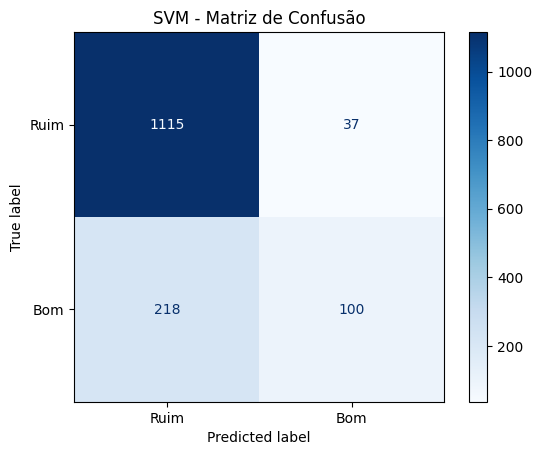

SVM - ROC-AUC: 0.84


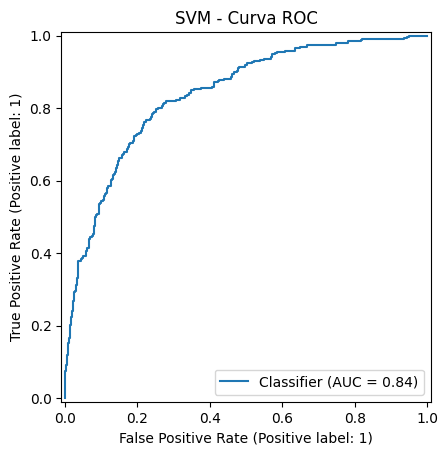

In [10]:
# Treinar e avaliar SVM
##probability=True: Permite calcular probabilidades para ROC-AUC.
##Kernel padrão: RBF (não linear).
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
evaluate_binary(svm, X_test_scaled, y_test, "SVM", scaled=True)

Árvore de Decisão - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1152
           1       0.62      0.62      0.62       318

    accuracy                           0.83      1470
   macro avg       0.76      0.76      0.76      1470
weighted avg       0.83      0.83      0.83      1470



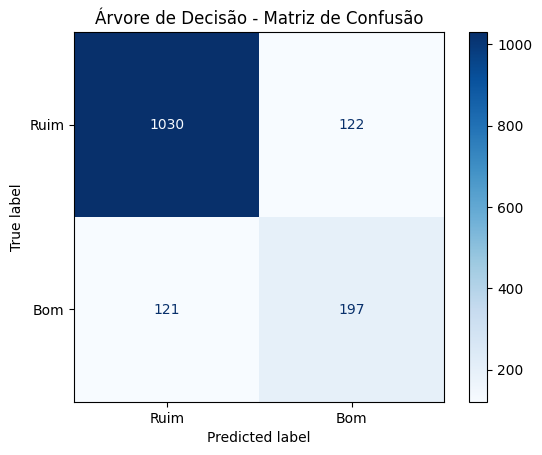

Árvore de Decisão - ROC-AUC: 0.76


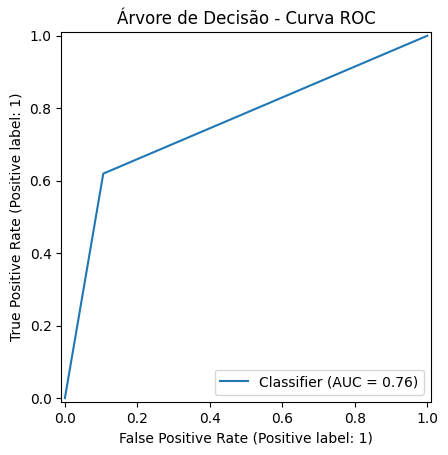

In [11]:
# Treinar e avaliar Árvore de Decisão
##Não requer padronização.
##Sensível a overfitting (pode ser controlado com max_depth ou min_samples_split).
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
evaluate_binary(dt, X_test, y_test, "Árvore de Decisão")

Gradient Boosting - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1152
           1       0.67      0.38      0.49       318

    accuracy                           0.83      1470
   macro avg       0.76      0.66      0.69      1470
weighted avg       0.81      0.83      0.81      1470



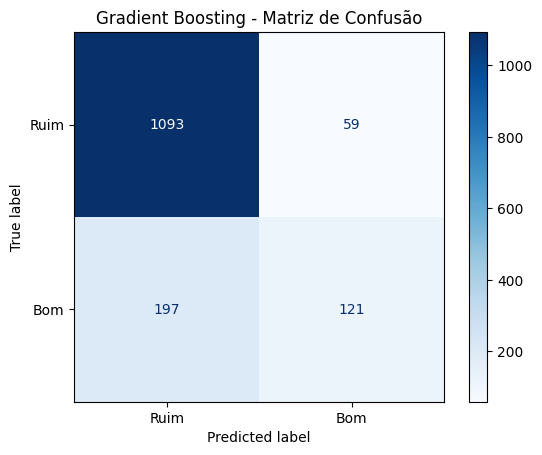

Gradient Boosting - ROC-AUC: 0.86


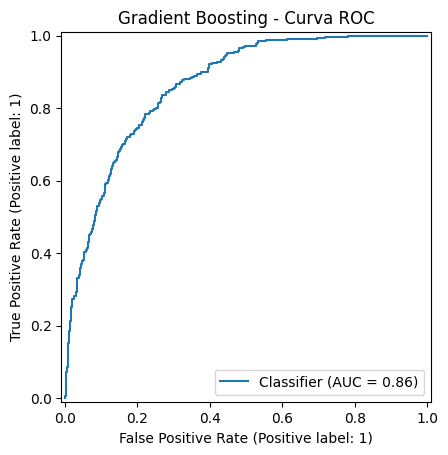


Validação Cruzada (5 folds) - Gradient Boosting:
AUC médio: 0.85 (± 0.01)
Gradient Boosting - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1152
           1       0.67      0.38      0.49       318

    accuracy                           0.83      1470
   macro avg       0.76      0.66      0.69      1470
weighted avg       0.81      0.83      0.81      1470



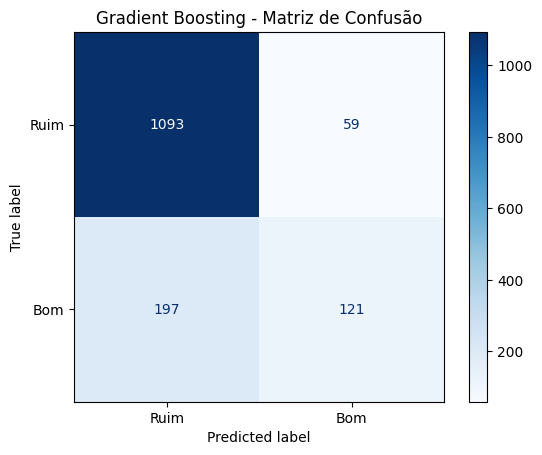

Gradient Boosting - ROC-AUC: 0.86


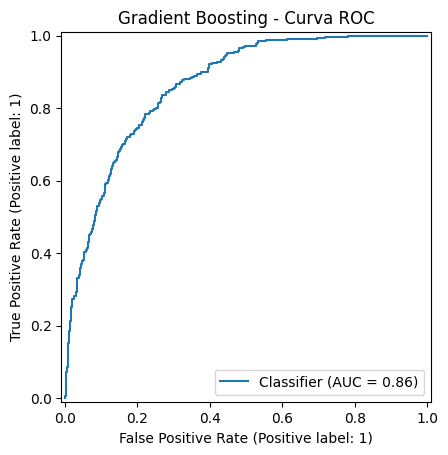


Melhores hiperparâmetros encontrados:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Gradient Boosting Otimizado - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1152
           1       0.77      0.61      0.68       318

    accuracy                           0.88      1470
   macro avg       0.83      0.78      0.80      1470
weighted avg       0.87      0.88      0.87      1470



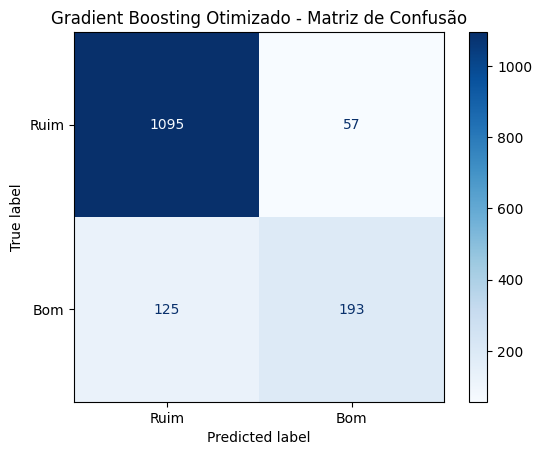

Gradient Boosting Otimizado - ROC-AUC: 0.90


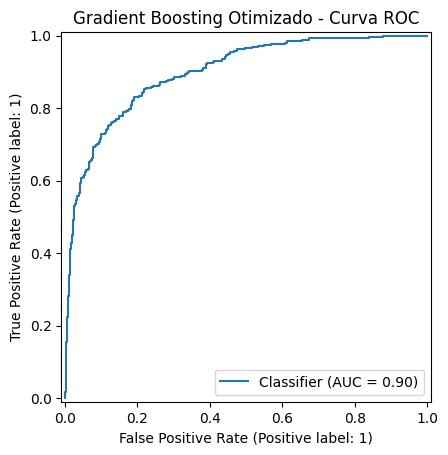

In [12]:
# Treinar e avaliar Gradient Boosting
##Ensemble de árvores de decisão (combina modelos fracos sequencialmente).
##Menos propenso a overfitting que árvores individuais.
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
evaluate_binary(gb, X_test, y_test, "Gradient Boosting")


# Treinar e avaliar Gradient Boosting com Validação Cruzada
gb = GradientBoostingClassifier(random_state=42)

# Configurar validação cruzada estratificada (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliação com validação cruzada
cv_scores = cross_val_score(gb, X_train, y_train, cv=cv, scoring='roc_auc')
print("\nValidação Cruzada (5 folds) - Gradient Boosting:")
print(f"AUC médio: {cv_scores.mean():.2f} (± {cv_scores.std():.2f})")

# Treinar o modelo final com todos os dados de treino
gb.fit(X_train, y_train)

# Avaliação no conjunto de teste
evaluate_binary(gb, X_test, y_test, "Gradient Boosting")

# [Opcional] Otimização de hiperparâmetros com GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42),
                         param_grid,
                         cv=cv,
                         scoring='roc_auc',
                         n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nMelhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

# Avaliar o melhor modelo no conjunto de teste
best_gb = grid_search.best_estimator_
evaluate_binary(best_gb, X_test, y_test, "Gradient Boosting Otimizado")

In [ ]:
def prever_manual():
    """
    Função para prever a qualidade do vinho (Bom ou Ruim) com base em valores inseridos manualmente.
    Utiliza o modelo Gradient Boosting otimizado treinado anteriormente.

    Requer a entrada dos seguintes parâmetros (características do vinho):
    - fixed acidity
    - volatile acidity
    - citric acid
    - residual sugar
    - chlorides
    - free sulfur dioxide
    - total sulfur dioxide
    - density
    - pH
    - sulphates
    - alcohol

    Retorna a probabilidade de ser "Bom" (>=7) e a classificação final.
    """

    # Verificar se o modelo otimizado foi treinado
    if 'best_gb' not in globals():
        raise ValueError("Modelo Gradient Boosting não foi treinado. Execute o GridSearchCV primeiro.")

    print("Insira os valores das características do vinho para prever a qualidade (Bom >=7 / Ruim <7):")

    # Coletar inputs do usuário
    features = [
        'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
        'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
        'pH', 'sulphates', 'alcohol'
    ]

    input_data = []
    for feature in features:
        value = float(input(f"{feature}: "))
        input_data.append(value)

    # Criar DataFrame com os dados de entrada
    input_df = pd.DataFrame([input_data], columns=features)

    # Fazer a previsão
    proba = best_gb.predict_proba(input_df)[0][1]  # Probabilidade de ser "Bom"
    prediction = best_gb.predict(input_df)[0]       # Classificação (0 ou 1)

    # Exibir resultados
    print("\nResultado da Predição:")
    print(f"- Probabilidade de ser 'Bom': {proba*100:.1f}%")
    print(f"- Classificação: {'Bom (>=7)' if prediction == 1 else 'Ruim (<7)'}")

    return {"probabilidade": proba, "classificacao": prediction}

# Exemplo de uso:
prever_manual()

Insira os valores das características do vinho para prever a qualidade (Bom >=7 / Ruim <7):
fixed acidity: 7.4
volatile acidity: 0.7
citric acid: 0.0
residual sugar: 1.9
chlorides: 0.076
free sulfur dioxide: 11.0
total sulfur dioxide: 34.0
density: 0.9978
pH: 3.51
sulphates: 0.56
alcohol: 9.4

Resultado da Predição:
- Probabilidade de ser 'Bom': 0.1%
- Classificação: Ruim (<7)


{'probabilidade': np.float64(0.0013148605489347604),
 'classificacao': np.int64(0)}